ReliefF 计算的特征重要性排序： ['Glucose', 'BMI', 'SkinThickness', 'Pregnancies', 'Age', 'DiabetesPedigreeFunction', 'BloodPressure', 'Insulin']
自动生成的区域映射：
Glucose: (0, 0, 80, 80)
BMI: (80, 0, 40, 60)
SkinThickness: (0, 80, 50, 40)
Pregnancies: (50, 80, 40, 30)
Age: (80, 60, 40, 20)
DiabetesPedigreeFunction: (90, 80, 30, 20)
BloodPressure: (50, 110, 25, 10)
Insulin: (75, 110, 20, 10)


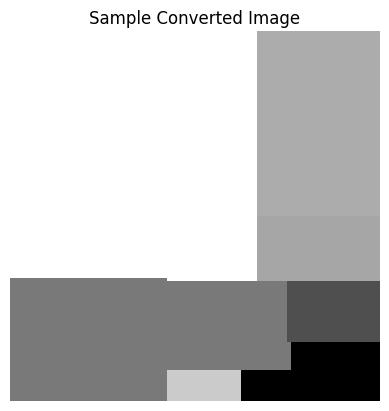

正在提取训练集特征...


d:\AppsFiles\Anaconda3\envs\tor_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AppsFiles\Anaconda3\envs\tor_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


训练集特征形状： (614, 512)
正在提取测试集特征...
测试集特征形状： (154, 512)
SVM Test Accuracy: 54.55%
SVM ROC AUC: 0.6581


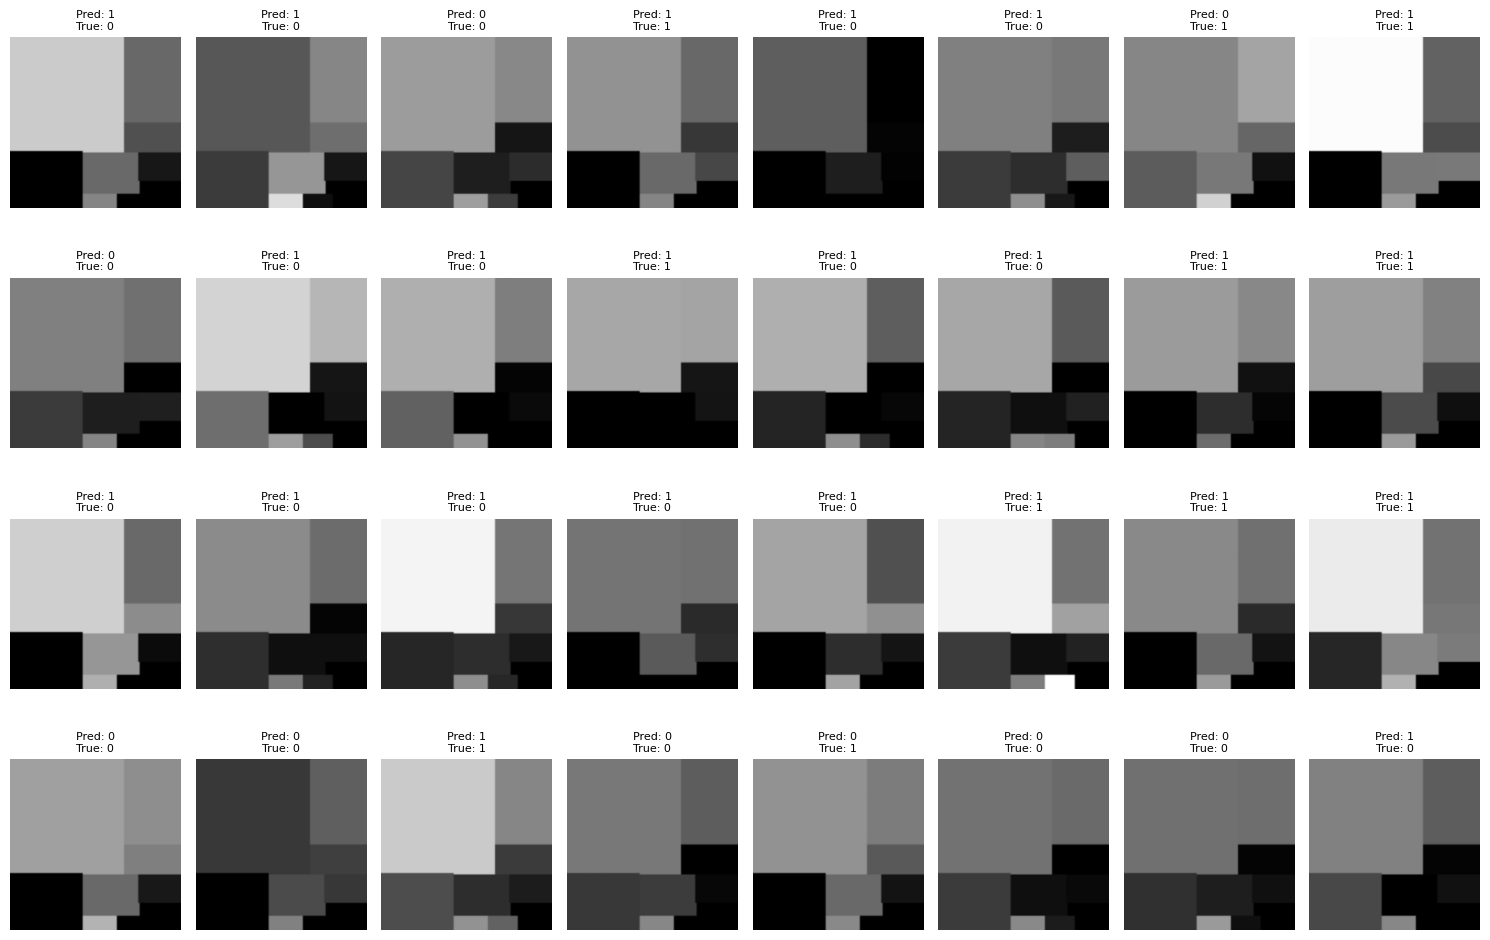

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# ---------------------- 1. 数据加载与归一化 ----------------------
# CSV 文件包含的特征
feature_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

data = pd.read_csv('diabetes_dataset_1.csv')

# 对所有特征进行 min–max 归一化
data_norm = data.copy()
for col in feature_cols:
    min_val = data[col].min()
    max_val = data[col].max()
    data_norm[col] = (data[col] - min_val) / (max_val - min_val)

# ---------------------- 2. 利用 ReliefF 自动计算特征重要性 ----------------------
# 需要安装 skrebate：pip install skrebate
from skrebate import ReliefF

X = data_norm[feature_cols].values
y = data_norm['Outcome'].values

relief = ReliefF(n_neighbors=10)
relief.fit(X, y)
importance_scores = relief.feature_importances_

# 按照重要性降序排列，得到特征名称排序
ordered_indices = np.argsort(importance_scores)[::-1]
ordered_features = [feature_cols[i] for i in ordered_indices]
print("ReliefF 计算的特征重要性排序：", ordered_features)

# ---------------------- 3. 根据排序自动生成区域映射 ----------------------
# 定义预先设计好的区域列表，按面积从大到小排列（格式：(x, y, width, height)）
predefined_regions = [
    (0, 0, 80, 80),    # 面积：80x80=6400，分配给最重要的特征
    (80, 0, 40, 60),   # 面积：40x60=2400
    (0, 80, 50, 40),   # 面积：50x40=2000
    (50, 80, 40, 30),  # 面积：40x30=1200
    (80, 60, 40, 20),  # 面积：40x20=800
    (90, 80, 30, 20),  # 面积：30x20=600
    (50, 110, 25, 10), # 面积：25x10=250
    (75, 110, 20, 10)  # 面积：20x10=200
]

# 如果有自定义映射，可在此处指定，否则使用自动生成的映射
self_region_mapping = {
    "Age": (0, 0, 69, 60),                     # Feature_7
    "SkinThickness": (69, 0, 51, 60),          # Feature_3
    "BMI": (0, 60, 59, 40),                    # Feature_5
    "Pregnancies": (59, 60, 32, 40),           # Feature_0
    "Insulin": (91, 60, 29, 40),               # Feature_4
    "DiabetesPedigreeFunction": (0, 100, 75, 20),  # Feature_6
    "BloodPressure": (75, 100, 39, 20),        # Feature_2
    "Glucose": (114, 100, 6, 20)               # Feature_1
}

# 自动将预定义区域分配给排序后的特征
auto_region_mapping = {}
for i, feat in enumerate(ordered_features):
    auto_region_mapping[feat] = predefined_regions[i]

print("自动生成的区域映射：")
for feat, region in auto_region_mapping.items():
    print(f"{feat}: {region}")

# ---------------------- 4. 数值到图像转换函数 ----------------------
def create_image_from_features(sample, region_mapping):
    """
    根据单个样本的归一化特征和给定的 region_mapping 生成 120x120 灰度图像
    """
    img = Image.new('L', (120, 120), color=0)  # 创建黑底图
    draw = ImageDraw.Draw(img)
    
    # 对于每个特征，根据 mapping 中的区域将值映射到 0-255 灰度值
    for feat in feature_cols:
        val = int(sample[feat] * 255)
        if feat in region_mapping:
            x, y, w, h = region_mapping[feat]
            draw.rectangle([x, y, x + w, y + h], fill=val)
    return img

# 可视化查看一个样本转换后的图像
sample_img = create_image_from_features(data_norm.iloc[0], auto_region_mapping)
plt.imshow(sample_img, cmap='gray')
plt.title("Sample Converted Image")
plt.axis('off')
plt.show()

# ---------------------- 5. 定义 PyTorch 数据集 ----------------------
class PimaImageDataset(Dataset):
    def __init__(self, df, transform=None, region_mapping=None):
        """
        df：包含归一化特征及 Outcome 的 DataFrame
        transform：数据增强变换
        region_mapping：数值到图像转换时使用的区域映射字典
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.region_mapping = region_mapping if region_mapping is not None else auto_region_mapping

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img = create_image_from_features(sample, self.region_mapping)
        label = int(sample['Outcome'])
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img, label

# ---------------------- 6. 数据增强与数据加载器 ----------------------
def convert_to_rgb(img):
    return img.convert('RGB')

train_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_norm, test_size=0.2, random_state=42, stratify=data_norm['Outcome'])

train_dataset = PimaImageDataset(train_df, transform=train_transform, region_mapping=auto_region_mapping)
test_dataset = PimaImageDataset(test_df, transform=test_transform, region_mapping=auto_region_mapping)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---------------------- 7. 使用预训练的 ResNet18 作为特征提取器 ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载预训练的 ResNet18 模型，并去掉最后的全连接层
model = models.resnet18(pretrained=True)
model.fc = nn.Identity()  # 将最后的全连接层置为恒等映射
model = model.to(device)
model.eval()  # 固定特征提取器

# ---------------------- 8. 提取训练集和测试集的特征 ----------------------
import time

def extract_features(data_loader, model, device):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            feats = model(imgs)  # 得到特征向量
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

print("正在提取训练集特征...")
train_features, train_labels = extract_features(train_loader, model, device)
print("训练集特征形状：", train_features.shape)

print("正在提取测试集特征...")
test_features, test_labels = extract_features(test_loader, model, device)
print("测试集特征形状：", test_features.shape)

# ---------------------- 9. 使用 SVM 进行分类 ----------------------
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# 使用线性核的 SVM 进行训练
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(train_features, train_labels)

# 在测试集上预测
test_preds = svm_clf.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print(f"SVM Test Accuracy: {test_acc*100:.2f}%")

# 计算 ROC AUC（假设二分类问题，使用预测概率）
test_probs = svm_clf.predict_proba(test_features)[:, 1]
roc_auc = roc_auc_score(test_labels, test_probs)
print(f"SVM ROC AUC: {roc_auc:.4f}")

# ---------------------- 10. 可视化部分 ----------------------
# 取测试集中的一个 batch，使用 CNN 提取特征后，用 SVM 得到预测结果，展示图像
import math

model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
with torch.no_grad():
    feats = model(images)
feats_np = feats.cpu().numpy()
# SVM预测
svm_preds = svm_clf.predict(feats_np)

images_np = images.cpu().numpy().transpose((0, 2, 3, 1))

batch_size = images_np.shape[0]
cols = 8
rows = math.ceil(batch_size / cols)
plt.figure(figsize=(15, 2.5 * rows))
for i in range(batch_size):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images_np[i])
    plt.title(f"Pred: {svm_preds[i]}\nTrue: {labels[i].item()}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()
